BERT and modern large language models, go beyond simply relying on ngrams for language understanding. While ngrams capture local word dependencies (pairs of consecutive words), BERT leverages a more sophisticated approach

While BERT's tokenizer may internally break down words into subword units that are essentially like n-grams of characters or word pieces, it doesn't explicitly rely on the traditional n-gram frequency-based approach for language modeling.

Instead, BERT learns deeper contextual relationships through its Transformer architecture, making it capable of handling nuances like sarcasm and long-range dependencies that traditional n-gram models might struggle with.

 BERT's fundamental strength lies in its ability to learn contextualized word embeddings through its bidirectional Transformer architecture, rather than explicitly relying on trigram frequency counts for its core functionality.

In [72]:
import random

In [73]:
random.seed(10)

In [74]:
%pip install swifter

In [75]:
%pip install python-dotenv

In [76]:
%pip install bertopic

In [ ]:
#%pip install openai
#%pip install openai==1.0.0

In [77]:
!pip install gensim

In [78]:
%pip install tensorflow

In [79]:
%pip install sentence-transformers

In [80]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
import plotly.express as px
import matplotlib.pyplot as plt

from datetime import datetime
import logging
import os
import sys
import time
import re

from dotenv import load_dotenv
#import openai
import swifter
from sentence_transformers import SentenceTransformer


from bertopic import BERTopic
import joblib
from sklearn.preprocessing import normalize
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [81]:
from google.colab import drive
drive.mount('/content/gdrive')
df = pd.read_csv('/content/gdrive/MyDrive/DATA/palm_oil_grievance_logs.csv')
df

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,pk,source,internal_id,status,submitted_on,accepted_on,last_updated_on,country,region,complainants,respondents,respondent_sector,respondent_parent_company,respondent_supplier,summary,history,external_link,extras
0,1,Roundtable on Sustainable Palm Oil (RSPO),500Mg00000L0di6IAB,Closed,2/26/2025,4/15/2025,5/20/2025,Indonesia,Sumatera Selatan,Confidential,PT Sawit Mas Sejahtera,Oil Palm Growers,Golden Agri-Resources (GAR),NaN,That the Respondent allegedly transferred the ...,2025-05-20: CP's Decision Letter dated 20. 05....,https://rspo.my.site.com/Complaint/s/case/500M...,{'case_number': 'RSPO/2025/02/RR'}
1,2,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVwYqYAK,In Progress - Investigation,11/29/2024,1/16/2025,1/16/2025,Mexico,NaN,Confidential,INDUSTRIAS OLEOPALMA S.A. DE C.V.,Oil Palm Growers,Oleoquímica Mexicana S.A. de C.V.,NaN,The Complainant alleges that the Respondent ha...,2025-04-30: The Secretariat furnished the Resp...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/17/MAM'}
2,3,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVxmPYAS,In Progress - Investigation,11/28/2024,1/21/2025,1/21/2025,Colombia,Montes de María,Confidential,OLEOFLORES S A S,Processors and/or Traders,Musim Mas Holdings Pte.,NaN,1.The Complainant alleges that the Respondent ...,2025-04-30: The Complaints Panels directive to...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/18/HN'}
3,4,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVGg2YAG,In Progress - Investigation,10/16/2024,11/18/2024,11/18/2024,Indonesia,Riau,S. Samsul Hadi,PT Guntung Idamannusa,Oil Palm Growers,Compañía Industrial Aceitera Coto Cincuenta y ...,NaN,The Respondent's Corporate Social Responsibili...,2025-04-30: The Complaints Panel has directed ...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/14/RH'}
4,5,Roundtable on Sustainable Palm Oil (RSPO),500GB00003vMwFgYAK,In Progress - Investigation,9/11/2024,10/29/2024,10/29/2024,Costa Rica,Pococi/Limón,Confidential,Compañía Palma Tica S.A.,Oil Palm Growers,NaN,NaN,The Complainant alleges that the Respondent br...,2025-04-30: The Briefing Note is in progress. ...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/13/MAM'}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,426,Wilmar International,NaN,Closed,8/19/2015,NaN,NaN,NaN,NaN,Greenomics Indonesia,"Sumatra Jaya Agro Lestari (SJAL), a subsidiary...",NaN,NaN,NaN,Alleged construction of canal to prepare for d...,Dialogue initiated with PT Sumatra Jaya Agro L...,http://www.greenomics.org/docs/IPOP_Implementa...,NaN
426,427,Wilmar International,NaN,Closed,7/1/2015,NaN,NaN,NaN,NaN,Greenomics Indonesia,"Patiware, a subsidiary of GAMA Plantation",NaN,NaN,NaN,NaN,Dialogue initiated with Ganda Group on the fir...,http://www.greenomics.org/docs/The%20Grievance...,NaN
427,428,Wilmar International,NaN,Closed,5/30/2015,NaN,NaN,NaN,NaN,Action Network - Forest Heroes,Setia Agrindo Lestari (SAL) an affiliate* of F...,NaN,NaN,NaN,NaN,Dialogue initiated with First Resources in the...,https://www.thejakartapost.com/news/2015/05/12...,NaN
428,429,Wilmar International,NaN,Closed,6/5/2015,NaN,NaN,NaN,NaN,Greenomics Indonesia,Sawit Sumbermas Sarana (SSS),NaN,NaN,NaN,Alleged clearance of potential High Carbon Sto...,Following a couple of NGO reports about Sawit ...,http://www.greenomics.org/docs/IPOP_Implementa...,NaN


In [82]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis notebook was produced without a GPU runtime. Enable a GPU runtime '
      'by going to Runtime > Change runtime type > Hardware accelerator > GPU.'
  )
else:
  print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [83]:
from gensim.models.phrases import Phrases, Phraser


In [84]:
print(df.columns)

Index(['pk', 'source', 'internal_id', 'status', 'submitted_on', 'accepted_on',
       'last_updated_on', 'country', 'region', 'complainants', 'respondents',
       'respondent_sector', 'respondent_parent_company', 'respondent_supplier',
       'summary', 'history', 'external_link', 'extras'],
      dtype='object')


In [ ]:
# stop_words = set(stopwords.words('english'))
# punctuation = set(string.punctuation)

# def clean_text(text):
#     import re
#     import string
#     from nltk.corpus import stopwords

#     if not isinstance(text, str):
#         text = str(text)

#     text = text.lower()
#     text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
#     tokens = text.split()

#     stop_words = set(stopwords.words('english'))
#     tokens = [word for word in tokens if word and word not in stop_words]

#     return tokens

# df["tokens"] = df["summary"].apply(clean_text)

# bigram_model = Phrases(df["tokens"], min_count=5, threshold=100)
# bigram_phraser = Phraser(bigram_model)

# df["tokens_bi"] = df["tokens"].apply(lambda x: bigram_phraser[x])

# words_to_filter = {'nan', 'pt','report','rspo','alleged', 'palm', 'oil', 'company', 'community',
#                    'complainants', 'companies', 'also', 'without', 'group', 'allegedly', 'period',
#                    'respondent', 'reported', 'mentioned', '2019', '19', '2020', 'subsidary', 'alleges',
#                    'respondent','Complainant','Final Countdown','report','Allegations','Greenpeace'
#                    ,'GAR','MightyEarth','BHD','mighty_earth','green_peace','greenpeace','lands'}

# df['flt_tokens'] = df["tokens_bi"].apply(lambda tokens: [word for word in tokens if word not in words_to_filter])



# df = pd.DataFrame({'flt_tokens': df['flt_tokens'].apply(lambda x: ' '.join(x))})

In [85]:
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

def clean_text(text):
    import re
    import string
    from nltk.corpus import stopwords

    if not isinstance(text, str):
        text = str(text)

    text = text.lower()
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
    tokens = text.split()

    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word and word not in stop_words]

    return tokens

df["tokens"] = df["summary"].apply(clean_text)

bigram_model = Phrases(df["tokens"], min_count=5, threshold=100)
bigram_phraser = Phraser(bigram_model)


df["tokens_bi"] = df["tokens"].apply(lambda x: bigram_phraser[x])

trigram_model = Phrases(df["tokens_bi"], min_count=3, threshold=100)
trigram_phraser = Phraser(trigram_model)
df["tokens_tri"] = df["tokens_bi"].apply(lambda x: trigram_phraser[x])


words_to_filter = {'nan', 'pt','report','rspo','alleged', 'palm', 'oil', 'company', 'community',
                   'complainants', 'companies', 'also', 'without', 'group', 'allegedly', 'period',
                   'respondent', 'reported', 'mentioned', '2019', '19', '2020', 'subsidary', 'alleges',
                   'respondent','Complainant','Final Countdown','report','Allegations','Greenpeace'
                   ,'GAR','MightyEarth','BHD','mighty_earth','green_peace','greenpeace','land'}

df['flt_tokens'] = df["tokens_tri"].apply(lambda tokens: [word for word in tokens if word not in words_to_filter])



df = pd.DataFrame({'flt_tokens': df['flt_tokens'].apply(lambda x: ' '.join(x))})

In [86]:
logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s', level=logging.INFO)

BATCH_SIZE = 100
output_dir = "../data/intermediate"
os.makedirs(output_dir, exist_ok=True)

# load model once
model = SentenceTransformer('all-MiniLM-L6-v2')

# define embedding function
def get_embedding(text) -> list:
    if not text:
        return None
    try:
        return model.encode(text)
    except Exception as e:
        logging.error(f"Error getting embedding for text: {str(text)[:50]}... Error: {e}")
        return None

# main batch embedding function
def run_local_embeddings():
    formatted_datetime = datetime.now().strftime("%d_%b_%Y_%H_%M_%S")
    n = len(df)
    df['embedding'] = [None] * n

    df_start = 0
    while df_start < n:
        df_intermediate = df[df_start:df_start + BATCH_SIZE].copy()

        # Only process rows that do NOT have numpy array embeddings yet
        df_intermediate_unprocessed = df_intermediate.loc[
            df_intermediate['embedding'].apply(lambda x: not isinstance(x, np.ndarray))
        ]
        unprocessed_rows = len(df_intermediate_unprocessed)

        if unprocessed_rows == 0:
            logging.info(f"No unprocessed rows in batch starting at {df_start}")
        else:
            logging.info(f"Running embeddings on {unprocessed_rows} rows in batch starting at {df_start}")
            try:
                df_intermediate_unprocessed["embedding"] = df_intermediate_unprocessed["flt_tokens"].swifter.apply(
                    get_embedding
                )

                successful = df_intermediate_unprocessed.loc[
                    df_intermediate_unprocessed['embedding'].apply(lambda x: isinstance(x, np.ndarray))
                ]
                df.loc[successful.index, 'embedding'] = successful['embedding']

            except Exception as exc:
                logging.exception(f"Exception during embedding: {exc}")

        # save partial batch
        df.to_pickle(f"{output_dir}/embeddings_partial_{df_start}_{formatted_datetime}.pkl")
        df_start += BATCH_SIZE

    # save full dataset
    df.to_pickle(f"{output_dir}/embeddings_full_{formatted_datetime}.pkl")
    logging.info("Finished all batches and saved full dataset.")

run_local_embeddings()



Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/30 [00:00<?, ?it/s]

Model Creation

In [87]:
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [88]:
%pip install scikit-fuzzy

In [89]:
from skfuzzy.cluster import cmeans
from sentence_transformers import SentenceTransformer
import umap
import numpy as np

In [90]:
# # Define Clustering Models
# soft_kmeans_model = GaussianMixture(n_components=20, random_state=42)
class FuzzyCMeansModel:
    def __init__(self, n_clusters=10, m=2, error=0.005, maxiter=1000):
        self.n_clusters = n_clusters
        self.m = m
        self.error = error
        self.maxiter = maxiter
        self.labels_ = None
        self.centers = None
        self.u = None  # Membership matrix

    def fit(self, X):
        self.centers, self.u, _, _, _, _, _ = cmeans(
            X.T, self.n_clusters, self.m, error=self.error, maxiter=self.maxiter
        )
        self.labels_ = np.argmax(self.u, axis=0)
        return self

    def predict(self, X):
        return self.labels_

In [91]:
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic

In [92]:
## bertopic.py ##

# Filter out rows where the 'embedding' is None
df_embeddings = df.dropna(subset=['embedding']).copy()

# Normalize embeddings and store them in a new column
df_embeddings['embedding_normalized'] = df_embeddings['embedding'].apply(
  lambda x: normalize([x], norm='l2')[0]
)
embeddings_array = np.array(df_embeddings['embedding_normalized'].tolist())

# Use the cleaned text for docs
docs = df_embeddings['flt_tokens'].tolist()

# Initialize BERTopic model with a random_state for reproducibility

cluster_model = FuzzyCMeansModel(n_clusters= 10)
bertopic_model = BERTopic(hdbscan_model=cluster_model)



# Fit model
topics, probs = bertopic_model.fit_transform(docs, embeddings_array)

# Get actual fuzzy topic probabilities from the Fuzzy C-Means model
membership_probs = cluster_model.u.T  # shape = (n_docs, n_topics)

# Turn it into a DataFrame
membership_df = pd.DataFrame(membership_probs, columns=[f"Topic_{i}" for i in range(cluster_model.n_clusters)])

# Join with df_embeddings
df_embeddings = df_embeddings.reset_index(drop=True)
df_embeddings = pd.concat([df_embeddings, membership_df], axis=1)

# Now you can access per-topic probabilities per document
df_embeddings.head()

df_embeddings["topic"] = membership_df.idxmax(axis=1).apply(lambda x: int(x.split("_")[1]))
df_embeddings["probs"] = membership_df.max(axis=1)


# Print the topics and their top words after fitting the model
print("BERTopic Topics and Top Words:")
print(bertopic_model.get_topics())

# Reduce outliers (optional)
# This requires the original documents, so we use df_embeddings['flt_tokens']
# new_topics = bertopic_model.reduce_outliers(
#   df_embeddings['flt_tokens'].tolist(), topics, strategy="distributions"
# )
# df_embeddings['new_topic'] = new_topics


### we could try strategy="c-tf-idf"

# Get the current datetime for the filename
formatted_datetime = datetime.now().strftime("%d_%b_%Y_%H_%M_%S")

# Create the output directory for embeddings if it doesn't exist
output_embeddings_dir = "../data/embeddings"
os.makedirs(output_embeddings_dir, exist_ok=True)

# Save dataframe with topics and probabilities
df_embeddings.to_csv(
  f"{output_embeddings_dir}/feedback_embeddings_bertopic_{formatted_datetime}.csv",
  index=False
)

# Create the output directory for models if it doesn't exist
output_models_dir = "../models"
os.makedirs(output_models_dir, exist_ok=True)

# save the model for future use on unseen data
joblib.dump(
  bertopic_model,
  f"{output_models_dir}/bertopic_model_{formatted_datetime}.joblib"
)

print("BERTopic model worked.")

BERTopic Topics and Top Words:
{0: [('concession', 0.10211379661425453), ('ha', 0.10119655226875778), ('mightyearthrapidresponse', 0.08948280620617395), ('deforestation', 0.0830349529238372), ('total', 0.0753002248254731), ('cleared', 0.07461368990648073), ('hectares', 0.0615138127683657), ('may', 0.0507814641565778), ('forest', 0.046305772656680795), ('2021', 0.04563846482445509)], 1: [('workers', 0.12466819682936266), ('labour', 0.07640480947476842), ('union', 0.06442629951052244), ('dailycasualworkers', 0.05280947827358604), ('rights', 0.04030207893556885), ('work', 0.03347860961204774), ('payment', 0.0316038321532953), ('complainant', 0.03128632052441239), ('employment', 0.030477774679361982), ('bpjs', 0.027356651654542184)], 2: [('land', 0.030418844828475986), ('sustainable', 0.02393821831584172), ('rspos', 0.02260831729829496), ('communities', 0.01935930045769016), ('complaint', 0.01935491814220186), ('plantation', 0.018610773321051568), ('npp', 0.018570755588203723), ('certifica

In [93]:
df_embeddings['probs']

,probs
0,0.907858
1,0.820790
2,0.710538
3,0.375933
4,0.577943
...,...
382,0.464600
383,0.567532
384,0.866544
385,0.614524


In [94]:
print(bertopic_model.get_topic_info())

   Topic  Count                                               Name  \
0      0     51  0_concession_ha_mightyearthrapidresponse_defor...   
1      1     50          1_workers_labour_union_dailycasualworkers   
2      2     42               2_land_sustainable_rspos_communities   
3      3     42                             3_gar_supplier_ffb_eof   
4      4     36                  4_land_compensation_rights_people   
5      5     35  5_complainantalleges_complainant_land_allegations   
6      6     35                          6_area_fire_forest_permit   
7      7     34                  7_clearance_forest_peatlands_peat   
8      8     32                       8_plasma_operations_hcv_land   
9      9     30                     9_deforestation_gar_sawit_raya   

                                      Representation  \
0  [concession, ha, mightyearthrapidresponse, def...   
1  [workers, labour, union, dailycasualworkers, r...   
2  [land, sustainable, rspos, communities, compla...   
3  [g

In [95]:
# Get the topic information DataFrame
topic_info_df = bertopic_model.get_topic_info()

#print(topic_info_df['Representation'])
# Iterate through the 'Representation' column and print each list of words
for index, representation in topic_info_df['Representation'].items():
    topic_id = topic_info_df.loc[index, 'Topic'] # Get the corresponding Topic ID
    print(f"Topic {topic_id} Representation: {representation}")

Topic 0 Representation: ['concession', 'ha', 'mightyearthrapidresponse', 'deforestation', 'total', 'cleared', 'hectares', 'may', 'forest', '2021']
Topic 1 Representation: ['workers', 'labour', 'union', 'dailycasualworkers', 'rights', 'work', 'payment', 'complainant', 'employment', 'bpjs']
Topic 2 Representation: ['land', 'sustainable', 'rspos', 'communities', 'complaint', 'plantation', 'npp', 'certification', '2013', 'general']
Topic 3 Representation: ['gar', 'supplier', 'ffb', 'eof', 'forest', 'nationalpark', 'plantations', 'tasmapuja', 'located', 'mill']
Topic 4 Representation: ['land', 'compensation', 'rights', 'people', 'plantation', 'local', 'state', 'development', 'claim', 'village']
Topic 5 Representation: ['complainantalleges', 'complainant', 'land', 'allegations', 'communities', 'process', 'complaint', 'parties', 'dispute', 'member']
Topic 6 Representation: ['area', 'fire', 'forest', 'permit', 'sungai', 'water', 'plantation', 'decree', 'garsupplychain', 'gar']
Topic 7 Represen

In [96]:
## bertopic.py ##

# Run each chunk in its own cell if in a notebook env

bertopic_model.visualize_topics() # intertopic distance map, shown below


In [97]:
bertopic_model.visualize_hierarchy()


In [98]:
hierarchical_topics = bertopic_model.hierarchical_topics(docs)
bertopic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 9/9 [00:00<00:00, 283.76it/s]


In [99]:
bertopic_model.visualize_barchart(top_n_topics=20, n_words=8, height=400, width=600)


In [100]:
bertopic_model.visualize_heatmap()

In [101]:
## bertopic.py ##

# Returns { topic_number: List[str] , ...}
rep_docs = bertopic_model.get_representative_docs()

rep_docs_df = pd.DataFrame.from_dict(rep_docs)
rep_docs_df.to_csv(
  f"../data/embeddings/representative_docs_{formatted_datetime}.csv",
  index=False
)

In [102]:
# This code adapts the LSA-based code to work with the BERTopic model.

# Ensure df_embeddings and bertopic_model are available
if 'df_embeddings' not in locals() or 'bertopic_model' not in locals():
    print("Error: 'df_embeddings' or 'bertopic_model' not found. Please run the data loading, embedding, and BERTopic modeling cells first.")
else:
    # Create a list of dictionaries to hold the data for the new DataFrame
    data = []

    # Iterate through the rows of df_embeddings
    for index, row in df_embeddings.iterrows():
        doc_num = index  # Use the original index as document number
        dominant_topic = row['topic']
        topic_prob = row['probs']
        text = row['flt_tokens'] # Use flt_tokens as the 'Text'

        # Get the keywords for the dominant topic from the BERTopic model
        # bertopic_model.get_topic returns a list of (word, score) tuples
        if dominant_topic != -1: # Exclude the outlier topic
            keywords = ", ".join([word for word, score in bertopic_model.get_topic(dominant_topic)])
        else:
            keywords = "Outlier Topic" # Or handle outlier topic as needed

        data.append({
            'Document_Num': doc_num,
            'Dominant_Topic': dominant_topic,
            'Topic_%_Contrib': topic_prob,
            'Keywords': keywords,
            'Text': text
        })

    # Create the DataFrame
    df_dominant_topic = pd.DataFrame(data)

    df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]

In [103]:
df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 7]

,Document_Num,Dominant_Topic,Topic_%_Contrib,Keywords,Text
38,38,7,0.863006,"clearance, forest, peatlands, peat, ran, leuse...",operating protected forest area license minist...
47,47,7,0.241216,"clearance, forest, peatlands, peat, ran, leuse...",dischargedimmense quantities toxic chemicals h...
50,50,7,0.325203,"clearance, forest, peatlands, peat, ran, leuse...",untreated wastewater disposed river stream
53,53,7,0.325293,"clearance, forest, peatlands, peat, ran, leuse...",land fires occurred august conservation area w...
59,59,7,0.851537,"clearance, forest, peatlands, peat, ran, leuse...",socfin indonesia used land apporoximately 900 ...
63,63,7,0.728920,"clearance, forest, peatlands, peat, ran, leuse...",sri ganda dissapointed towards unico desa plan...
70,70,7,0.626100,"clearance, forest, peatlands, peat, ran, leuse...",fpic process eia sia pollution
101,101,7,0.323374,"clearance, forest, peatlands, peat, ran, leuse...",orangutan found killed eaten concession susant...
104,104,7,0.866101,"clearance, forest, peatlands, peat, ran, leuse...",susantripermai kapuas maju jaya dwiewarna kary...
121,121,7,0.314805,"clearance, forest, peatlands, peat, ran, leuse...",ptnubikajaya mill polluted river aek baba cann...


In [104]:
# Input: Receives dataframe containing all rows with classification, table title, and number of topics
# Output: Displays n word clouds
def display_wordcloud(df, title, n_topics):

  n_cols = 2
  n_rows = int(np.ceil(n_topics / n_cols))
  fig = plt.figure(figsize=(14, 4 * n_rows))

  for topic in range(n_topics):
    topic_df = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == topic]
    text = ' '.join(topic_df['Text'].astype(str).tolist()) # Joining the words of each text of each row into a list separated by ' '
    text = re.sub(r'[^A-Za-z\s]', '', text) # Substituting/deleting anything that IS NOT a letter Aa-Zz with ''
    text = text.lower()
    # Fix: Convert words_to_filter set to a list before concatenation
    en_stop = set(stopwords.words('english') + list(words_to_filter))
    text = ' '.join(word for word in text.split() if word not in en_stop)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    ax = fig.add_subplot(n_rows, n_cols, topic + 1)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"Topic #{topic}")
    ax.axis("off")

  fig.suptitle(title, fontsize=32)
  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()


display_wordcloud(df=df_dominant_topic, title='Topic Classification Wordclouds', n_topics=7)

Output hidden; open in https://colab.research.google.com to view.

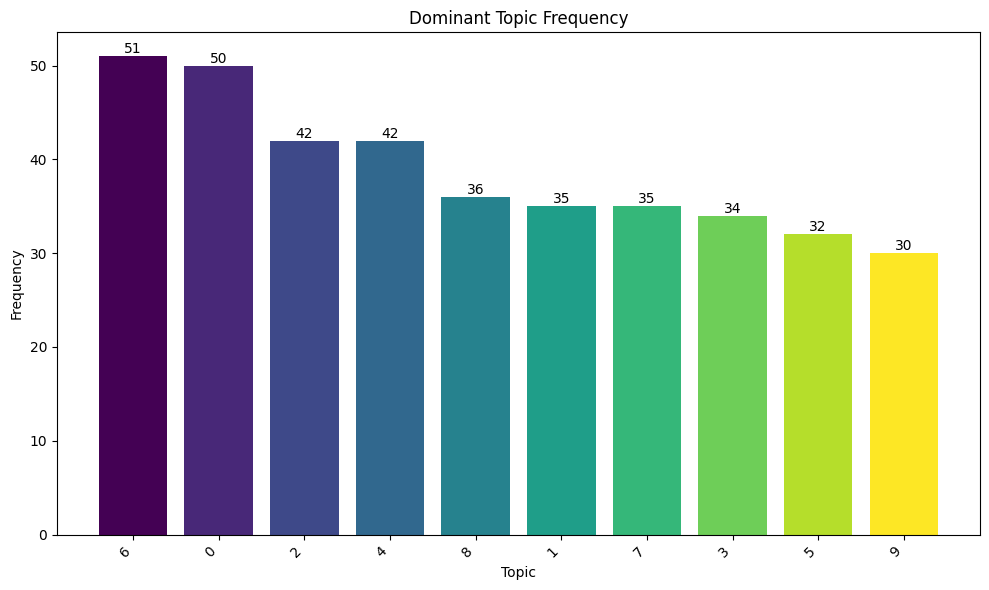

In [105]:
import matplotlib.pyplot as plt
import numpy as np # Import numpy if not already imported

# Ensure df_dominant_topic is available
if 'df_dominant_topic' not in locals():
    print("Error: 'df_dominant_topic' not found. Please run the cell that creates df_dominant_topic first.")
else:
    # Calculate topic share (frequency) from df_dominant_topic
    df_topic_share = df_dominant_topic.groupby(['Dominant_Topic'])['Document_Num'].count().reset_index()
    df_topic_share.columns = ['Topic', 'Frequency'] # Rename columns for clarity

    # Sort by frequency to potentially make the plot more informative
    df_topic_share = df_topic_share.sort_values('Frequency', ascending=False)


    # Define colors (optional, adjust as needed based on number of topics)
    # Ensure the number of colors matches the number of topics to display
    num_topics_to_plot = len(df_topic_share)
    # You can use a colormap to generate enough colors
    colors = plt.cm.viridis(np.linspace(0, 1, num_topics_to_plot))


    # Create the bar plot
    fig, ax = plt.subplots(figsize=(10, 6)) # Adjust figure size as needed

    # Plot the bars
    bars = ax.bar(df_topic_share['Topic'].astype(str), df_topic_share['Frequency'], color=colors)

    # Add labels to the bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center') # va: vertical alignment, ha: horizontal alignment

    # Set plot title and labels
    plt.title('Dominant Topic Frequency')
    plt.xlabel('Topic')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels if they overlap
    plt.tight_layout() # Adjust layout
    plt.show()